In [3]:
import numpy as np
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import re
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
allMovies = pd.read_csv('../../Data/serendipity-sac2018/movies.csv', 
                     error_bad_lines=False)
imdbData = pd.read_csv('../Intermediate_data/IMDb_data.csv')
trainClusters = pd.read_csv('../Intermediate_data/train_clusters.csv')

Skipping line 19833: expected 8 fields, saw 10
Skipping line 34143: expected 8 fields, saw 9
Skipping line 36015: expected 8 fields, saw 10
Skipping line 37260: expected 8 fields, saw 12
Skipping line 44379: expected 8 fields, saw 10
Skipping line 47551: expected 8 fields, saw 10



In [5]:
trainClusters.head()

,Unnamed: 0,index,userId,movieId,rating,timestamp,year,title,releaseDate,directedBy,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,nan,cluster
0,0,25353,142748,2762,5.0,2017-12-31 23:59:41,2017,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,...,0,0,1,0,0,0,0,0,0,0
1,1,26123,142752,2762,4.0,2017-12-31 20:41:29,2017,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,...,0,0,1,0,0,0,0,0,0,3
2,2,26180,142744,2762,4.0,2017-12-31 20:35:25,2017,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,...,0,0,1,0,0,0,0,0,0,1
3,3,26257,142753,2762,4.5,2017-12-31 20:19:35,2017,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,...,0,0,1,0,0,0,0,0,0,0
4,4,26651,142747,2762,3.0,2017-12-31 18:02:45,2017,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,...,0,0,1,0,0,0,0,0,0,0


In [6]:
imdbData.head()

,certificates,country codes,genres,kind,language codes,plot,rating,runtimes,votes,year,imdbId
0,"[u'Argentina:Atp', u'Australia:G', u'Belgium:K...",[u'us'],"[u'Animation', u'Adventure', u'Comedy', u'Fami...",movie,[u'en'],"[u""A cowboy doll is profoundly threatened and ...",8.3,[u'81'],837115.0,1995.0,114709
1,"[u'Argentina:Atp', u'Australia:PG', u'Brazil:1...",[u'us'],"[u'Adventure', u'Comedy', u'Family', u'Fantasy']",movie,"[u'en', u'fr']",[u'When two kids find and play a magical board...,7.0,[u'104'],287007.0,1995.0,113497
2,"[u'Argentina:Atp', u'Australia:PG', u'Finland:...",[u'us'],"[u'Comedy', u'Romance']",movie,"[u'en', u'it', u'de']","[u""John and Max resolve to save their beloved ...",6.7,[u'101'],23107.0,1995.0,113228
3,"[u'Argentina:16', u'Australia:M', u'Canada:14A...",[u'us'],"[u'Comedy', u'Drama', u'Romance']",movie,[u'en'],"[u""Based on Terry McMillan's novel, this film ...",5.9,[u'124'],9034.0,1995.0,114885
4,"[u'Argentina:Atp', u'Australia:G', u'Finland:S...",[u'us'],"[u'Comedy', u'Family', u'Romance']",movie,[u'en'],[u'George Banks must deal not only with the pr...,6.0,[u'106'],32568.0,1995.0,113041


## Format IMDb features

In [7]:
imdbData = imdbData.dropna()

In [8]:
imdbData['country codes'] = imdbData['country codes'].apply(lambda x: [str(s) for s in ast.literal_eval(x)])
imdbData['language codes'] = imdbData['language codes'].apply(lambda x: [str(s) for s in ast.literal_eval(x)])
imdbData['genres'] = imdbData['genres'].apply(lambda x: [str(s) for s in ast.literal_eval(x)])
imdbData['runtimes'] = imdbData['runtimes'].apply(lambda x: [int(s) for s in ast.literal_eval(x)][0])

In [9]:
imdbData.head()

,certificates,country codes,genres,kind,language codes,plot,rating,runtimes,votes,year,imdbId
0,"[u'Argentina:Atp', u'Australia:G', u'Belgium:K...",[us],"[Animation, Adventure, Comedy, Family, Fantasy]",movie,[en],"[u""A cowboy doll is profoundly threatened and ...",8.3,81,837115.0,1995.0,114709
1,"[u'Argentina:Atp', u'Australia:PG', u'Brazil:1...",[us],"[Adventure, Comedy, Family, Fantasy]",movie,"[en, fr]",[u'When two kids find and play a magical board...,7.0,104,287007.0,1995.0,113497
2,"[u'Argentina:Atp', u'Australia:PG', u'Finland:...",[us],"[Comedy, Romance]",movie,"[en, it, de]","[u""John and Max resolve to save their beloved ...",6.7,101,23107.0,1995.0,113228
3,"[u'Argentina:16', u'Australia:M', u'Canada:14A...",[us],"[Comedy, Drama, Romance]",movie,[en],"[u""Based on Terry McMillan's novel, this film ...",5.9,124,9034.0,1995.0,114885
4,"[u'Argentina:Atp', u'Australia:G', u'Finland:S...",[us],"[Comedy, Family, Romance]",movie,[en],[u'George Banks must deal not only with the pr...,6.0,106,32568.0,1995.0,113041


In [10]:
imdbData["kind"].value_counts()

movie             39500
tv movie           2357
video movie        1216
tv mini series      345
episode             132
tv series            85
tv short             62
Name: kind, dtype: int64

In [11]:
trainClusters.columns

Index([u'Unnamed: 0', u'index', u'userId', u'movieId', u'rating', u'timestamp',
       u'year', u'title', u'releaseDate', u'directedBy', u'starring',
       u'imdbId', u'tmdbId', u'genres', u'Action', u'Adventure', u'Animation',
       u'Children', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Fantasy',
       u'Film-Noir', u'Horror', u'IMAX', u'Musical', u'Mystery', u'Romance',
       u'Sci-Fi', u'Thriller', u'War', u'Western', u'nan', u'cluster'],
      dtype='object')

In [12]:
trainData = trainClusters.drop(['genres','Unnamed: 0'],axis=1).merge(imdbData, on = 'imdbId')

In [13]:
trainData["imdbRating"] = trainData["rating_y"]
trainData["userRating"] = trainData["rating_x"]
trainData["watchYear"] = trainData["year_x"]
trainData["releaseYear"] = trainData["year_y"]
trainData.drop(['rating_x', 'rating_y', 'year_x','year_y'], axis=1,inplace=True)
trainData.head()

,index,userId,movieId,timestamp,title,releaseDate,directedBy,starring,imdbId,tmdbId,...,genres,kind,language codes,plot,runtimes,votes,imdbRating,userRating,watchYear,releaseYear
0,25353,142748,2762,2017-12-31 23:59:41,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,"[Drama, Mystery, Thriller]",movie,"[en, la, es]",[u'A boy who communicates with spirits seeks t...,107,871881.0,8.1,5.0,2017,1999.0
1,26123,142752,2762,2017-12-31 20:41:29,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,"[Drama, Mystery, Thriller]",movie,"[en, la, es]",[u'A boy who communicates with spirits seeks t...,107,871881.0,8.1,4.0,2017,1999.0
2,26180,142744,2762,2017-12-31 20:35:25,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,"[Drama, Mystery, Thriller]",movie,"[en, la, es]",[u'A boy who communicates with spirits seeks t...,107,871881.0,8.1,4.0,2017,1999.0
3,26257,142753,2762,2017-12-31 20:19:35,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,"[Drama, Mystery, Thriller]",movie,"[en, la, es]",[u'A boy who communicates with spirits seeks t...,107,871881.0,8.1,4.5,2017,1999.0
4,26651,142747,2762,2017-12-31 18:02:45,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,"[Drama, Mystery, Thriller]",movie,"[en, la, es]",[u'A boy who communicates with spirits seeks t...,107,871881.0,8.1,3.0,2017,1999.0


In [14]:
trainData.columns

Index([u'index', u'userId', u'movieId', u'timestamp', u'title', u'releaseDate',
       u'directedBy', u'starring', u'imdbId', u'tmdbId', u'Action',
       u'Adventure', u'Animation', u'Children', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Fantasy', u'Film-Noir', u'Horror', u'IMAX',
       u'Musical', u'Mystery', u'Romance', u'Sci-Fi', u'Thriller', u'War',
       u'Western', u'nan', u'cluster', u'certificates', u'country codes',
       u'genres', u'kind', u'language codes', u'plot', u'runtimes', u'votes',
       u'imdbRating', u'userRating', u'watchYear', u'releaseYear'],
      dtype='object')

In [15]:
featureCols = [
    #Movie Genres
    'Action', 'Adventure', 'Animation', 'Children',
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
    'War', 'Western',
    #Additional Features
    'cluster', 'country codes', 'kind', 'language codes', 'runtimes', 'votes', 'imdbRating', 'releaseYear'
              ]

In [16]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(trainData['country codes'])
X = pd.DataFrame(X, columns=mlb.classes_)
movieCodesToUse = X[mlb.classes_].sum().sort_values(ascending=False, inplace=False)
movieCodesToUse = movieCodesToUse.index[:10]
movieCodesToUse
trainData = trainData.join(X[movieCodesToUse])

In [17]:
trainData.columns

Index([u'index', u'userId', u'movieId', u'timestamp', u'title', u'releaseDate',
       u'directedBy', u'starring', u'imdbId', u'tmdbId', u'Action',
       u'Adventure', u'Animation', u'Children', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Fantasy', u'Film-Noir', u'Horror', u'IMAX',
       u'Musical', u'Mystery', u'Romance', u'Sci-Fi', u'Thriller', u'War',
       u'Western', u'nan', u'cluster', u'certificates', u'country codes',
       u'genres', u'kind', u'language codes', u'plot', u'runtimes', u'votes',
       u'imdbRating', u'userRating', u'watchYear', u'releaseYear', u'us',
       u'gb', u'de', u'fr', u'ca', u'jp', u'nz', u'au', u'es', u'it'],
      dtype='object')

In [18]:
X = mlb.fit_transform(trainData['language codes'])
X = pd.DataFrame(X, columns=mlb.classes_)
langCodesToUse = X[mlb.classes_].sum().sort_values(ascending=False, inplace=False)
langCodesToUse = langCodesToUse.index[:10]

##Adding an l_ to the language codes to avoid clash with country codes
X.columns = ["l_" + l for l in X.columns]
langCodesToUse = ["l_" + l for l in langCodesToUse]
trainData = trainData.join(X[langCodesToUse])

In [19]:
X = mlb.fit_transform(trainData['kind'])
mlb.classes_

array([' ', 'd', 'e', 'h', 'i', 'm', 'n', 'o', 'p', 'r', 's', 't', 'v'],
      dtype=object)

In [20]:
trainData['kind'].value_counts()

movie             1177251
video movie          7070
tv movie             4487
tv mini series       3345
episode              2166
tv series            1900
tv short              457
Name: kind, dtype: int64

In [21]:
trainData['kind'] = trainData['kind'].apply(lambda x: 'movie' if x in ['movie', 'video movie'] else 'tv')

In [22]:
trainData['kind'].value_counts()

movie    1184321
tv         12355
Name: kind, dtype: int64

In [23]:

enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(np.array(trainData['kind']).reshape(-1, 1))
X = pd.DataFrame(X.toarray(), columns=enc.categories_)
trainData = trainData.join(X[enc.categories_])
trainData[["movie", "tv"]] = trainData.loc[:,trainData.columns[-2:]]
trainData.drop(trainData.columns[-4:-2], axis=1,inplace=True)

In [24]:
# Define 4 classes of ratings:
#     G : Suitable for all ages
#     PG : Parental Guidance required (Included PG-13, TV-Y7 etc. )
#     R : For adults/mature audience only
#     NR : Not Rated

certificatesDict = {
    "R" : "R",
    "PG-13" : "PG",
    "TV-14" : "PG",
    "PG" : "PG",
    "TV-PG" : "PG",
    "TV-MA" : "R",
    "TV-G" : "G",
    "Not Rated" : "NR",
    "G" : "G",
    "Unrated" : "NR",
    "Passed" : "G",
    "TV-Y7" : "G",
    "Approved" : "G",
    "TV-Y" : "G",
    "TV-Y7-FV" : "G",
    "M" : "PG",
    "GP" : "G",
    "NC-17" : "R",
    "M/PG" : "PG",
    "TV-13" : "PG",
    "X" : "R",
    "Open" : "NR",
    "AO" : "R"
}

def US_certificate(certificate):
    if len(certificate.split('United States')) < 2:
        return(np.nan)
    else:
        later_txt = certificate.split('United States')[1]
        UScert = re.match(r'\:(.*)',later_txt.split('\'')[0] ).group(1)
        UScert = UScert.split("::")[0]
        try:
            UScert = certificatesDict[UScert]
        except KeyError:
            print("Key not found for", UScert)
            UScert = "NR"
        return(UScert)

In [25]:
trainData["certificates"] = trainData["certificates"].apply(lambda x: US_certificate(x))
trainData["certificates"] = trainData["certificates"].fillna("NR")
trainData["certificates"].value_counts()
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(np.array(trainData['certificates']).reshape(-1, 1))
X = pd.DataFrame(X.toarray(), columns=enc.categories_)
trainData = trainData.join(X[enc.categories_])
trainData[["G", "NR", "PG", "R"]] = trainData.loc[:,trainData.columns[-4:]]
trainData.drop(trainData.columns[-8:-4], axis=1, inplace=True)

In [26]:
trainData.columns


Index([u'index', u'userId', u'movieId', u'timestamp', u'title', u'releaseDate',
       u'directedBy', u'starring', u'imdbId', u'tmdbId', u'Action',
       u'Adventure', u'Animation', u'Children', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Fantasy', u'Film-Noir', u'Horror', u'IMAX',
       u'Musical', u'Mystery', u'Romance', u'Sci-Fi', u'Thriller', u'War',
       u'Western', u'nan', u'cluster', u'certificates', u'country codes',
       u'genres', u'kind', u'language codes', u'plot', u'runtimes', u'votes',
       u'imdbRating', u'userRating', u'watchYear', u'releaseYear', u'us',
       u'gb', u'de', u'fr', u'ca', u'jp', u'nz', u'au', u'es', u'it', u'l_en',
       u'l_fr', u'l_es', u'l_de', u'l_it', u'l_ja', u'l_ru', u'l_ar', u'l_cmn',
       u'l_yue', u'movie', u'tv', u'G', u'NR', u'PG', u'R'],
      dtype='object')

In [27]:
trainData.head()

,index,userId,movieId,timestamp,title,releaseDate,directedBy,starring,imdbId,tmdbId,...,l_ru,l_ar,l_cmn,l_yue,movie,tv,G,NR,PG,R
0,25353,142748,2762,2017-12-31 23:59:41,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0
1,26123,142752,2762,2017-12-31 20:41:29,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0
2,26180,142744,2762,2017-12-31 20:35:25,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0
3,26257,142753,2762,2017-12-31 20:19:35,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0
4,26651,142747,2762,2017-12-31 18:02:45,"Sixth Sense, The (1999)",1999-08-06,M. Night Shyamalan,"Haley Joel Osment, Bruce Willis, Toni Collette...",167404,745.0,...,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0


In [152]:
clusterAvgs = trainData[["cluster", "imdbId", "userRating"]].groupby(["cluster", "imdbId"]).aggregate('mean').reset_index()


In [153]:
trainData.columns

Index([u'index', u'userId', u'movieId', u'timestamp', u'title', u'releaseDate',
       u'directedBy', u'starring', u'imdbId', u'tmdbId', u'Action',
       u'Adventure', u'Animation', u'Children', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Fantasy', u'Film-Noir', u'Horror', u'IMAX',
       u'Musical', u'Mystery', u'Romance', u'Sci-Fi', u'Thriller', u'War',
       u'Western', u'nan', u'cluster', u'certificates', u'country codes',
       u'genres', u'kind', u'language codes', u'plot', u'runtimes', u'votes',
       u'imdbRating', u'userRating', u'watchYear', u'releaseYear', u'us',
       u'gb', u'de', u'fr', u'ca', u'jp', u'nz', u'au', u'es', u'it', u'l_en',
       u'l_fr', u'l_es', u'l_de', u'l_it', u'l_ja', u'l_ru', u'l_ar', u'l_cmn',
       u'l_yue', u'movie', u'tv', u'G', u'NR', u'PG', u'R', u'ccode',
       u'lcode'],
      dtype='object')

In [154]:
movieFeatures = ["imdbId", "Action",
       "Adventure", "Animation", "Children", "Comedy", "Crime",
       "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "IMAX",
       "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War",
       "Western", "nan", "runtimes", "votes",
       "releaseYear", "us",
       "gb", "de", "fr", "ca", "jp", "nz", "au", "es", "it", "l_en",
       "l_fr", "l_es", "l_de", "l_it", "l_ja", "l_ru", "l_ar", "l_cmn",
       "l_yue", "movie", "tv", "G", "NR", "PG", "R"]
# , "ccode", "lcode", "kind", "certificates"]


In [155]:
# trainData["ccode"] = trainData["country codes"].astype('str')
# trainData["lcode"] = trainData["language codes"].astype('str')


In [156]:
clusterAvgs = clusterAvgs.merge(trainData[movieFeatures].drop_duplicates(), on = 'imdbId', how = 'left')
clusterAvgs.head()

,cluster,imdbId,userRating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,l_ru,l_ar,l_cmn,l_yue,movie,tv,G,NR,PG,R
0,0,417,3.907407,1,1,0,0,0,0,0,...,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0
1,0,439,3.468750,0,0,0,0,0,1,0,...,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0
2,0,455,2.600000,0,0,0,0,1,0,0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,499,2.000000,0,1,0,0,0,0,0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,534,2.000000,0,0,0,0,1,0,0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


## Regression Tree for Feature Importance

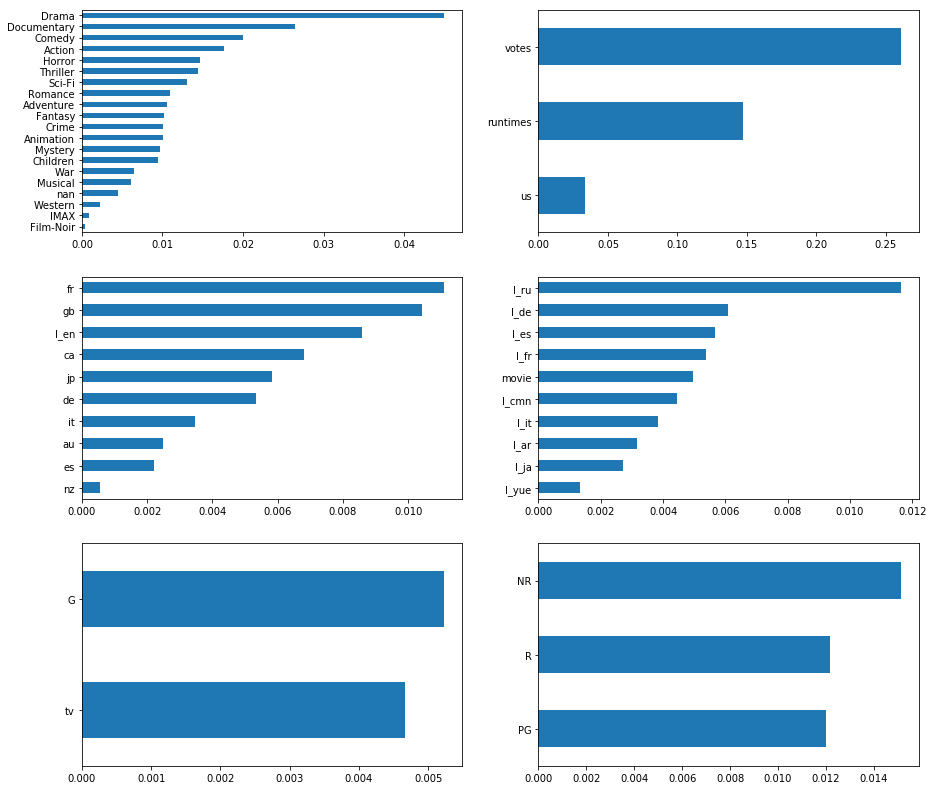

In [157]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 0]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
model = DecisionTreeRegressor()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

genreCols = feat_importances[:20]
featCols = feat_importances[[20,21,23]]
countryCols = feat_importances[24:34]
langCols = feat_importances[34:44]
kindCols = feat_importances[44:46]
ratingCols = feat_importances[46:]

c = [genreCols, featCols, countryCols, langCols, kindCols, ratingCols]
f, axes = plt.subplots(3, 2, figsize=(15, 5))
for i in range(6):
    c[i].sort_values(ascending = True).plot(kind='barh',ax=axes[i//2,i%2])    
    plt.subplots_adjust(bottom = 0.1 , top = 2.2)



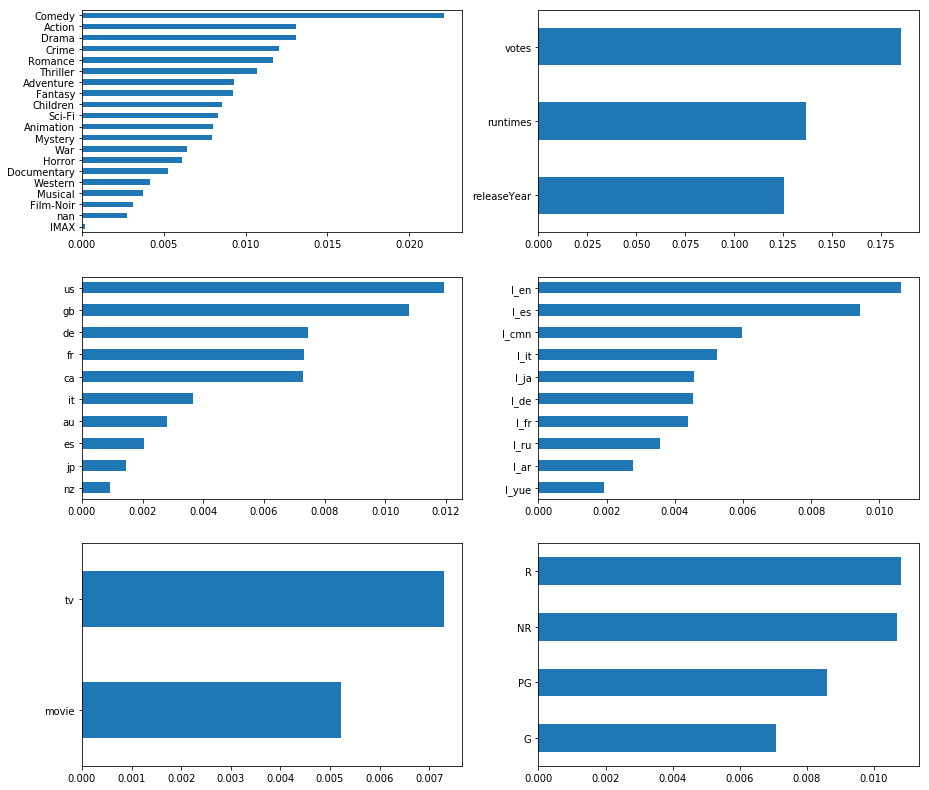

In [33]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 1]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
model = DecisionTreeRegressor()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

genreCols = feat_importances[:20]
featCols = feat_importances[[20,21,23]]
countryCols = feat_importances[24:34]
langCols = feat_importances[34:44]
kindCols = feat_importances[44:46]
ratingCols = feat_importances[46:]

c = [genreCols, featCols, countryCols, langCols, kindCols, ratingCols]
f, axes = plt.subplots(3, 2, figsize=(15, 5))
for i in range(6):
    c[i].sort_values(ascending = True).plot(kind='barh',ax=axes[i//2,i%2])    
    plt.subplots_adjust(bottom = 0.1 , top = 2.2)

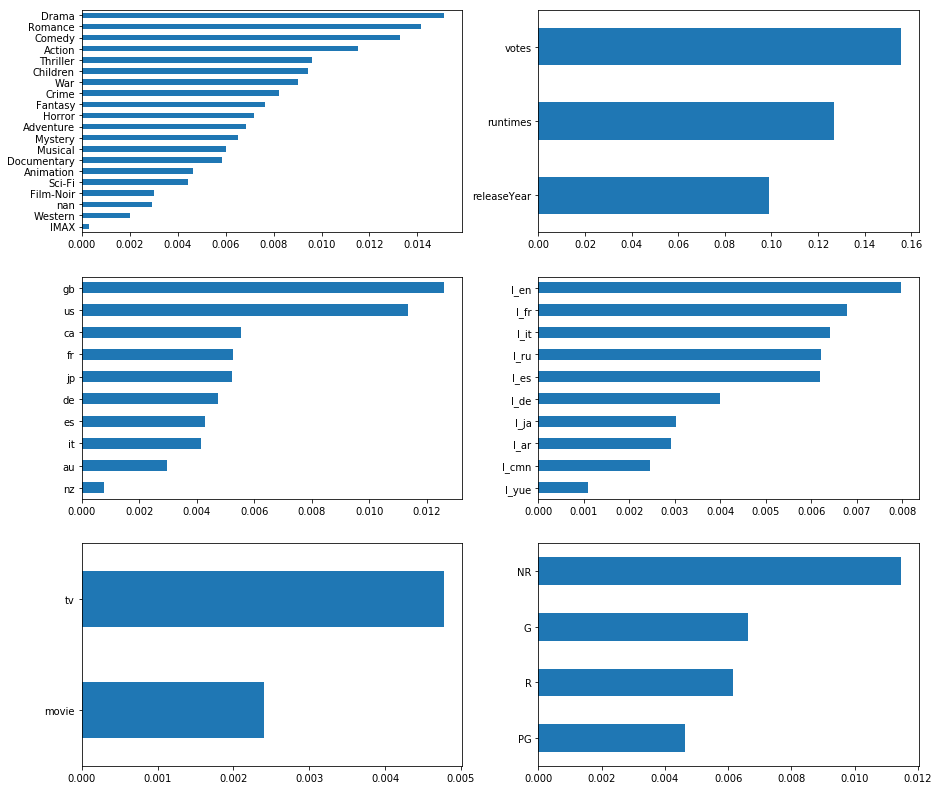

In [34]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 2]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
model = DecisionTreeRegressor()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

genreCols = feat_importances[:20]
featCols = feat_importances[[20,21,23]]
countryCols = feat_importances[24:34]
langCols = feat_importances[34:44]
kindCols = feat_importances[44:46]
ratingCols = feat_importances[46:]

c = [genreCols, featCols, countryCols, langCols, kindCols, ratingCols]
f, axes = plt.subplots(3, 2, figsize=(15, 5))
for i in range(6):
    c[i].sort_values(ascending = True).plot(kind='barh',ax=axes[i//2,i%2])    
    plt.subplots_adjust(bottom = 0.1 , top = 2.2)

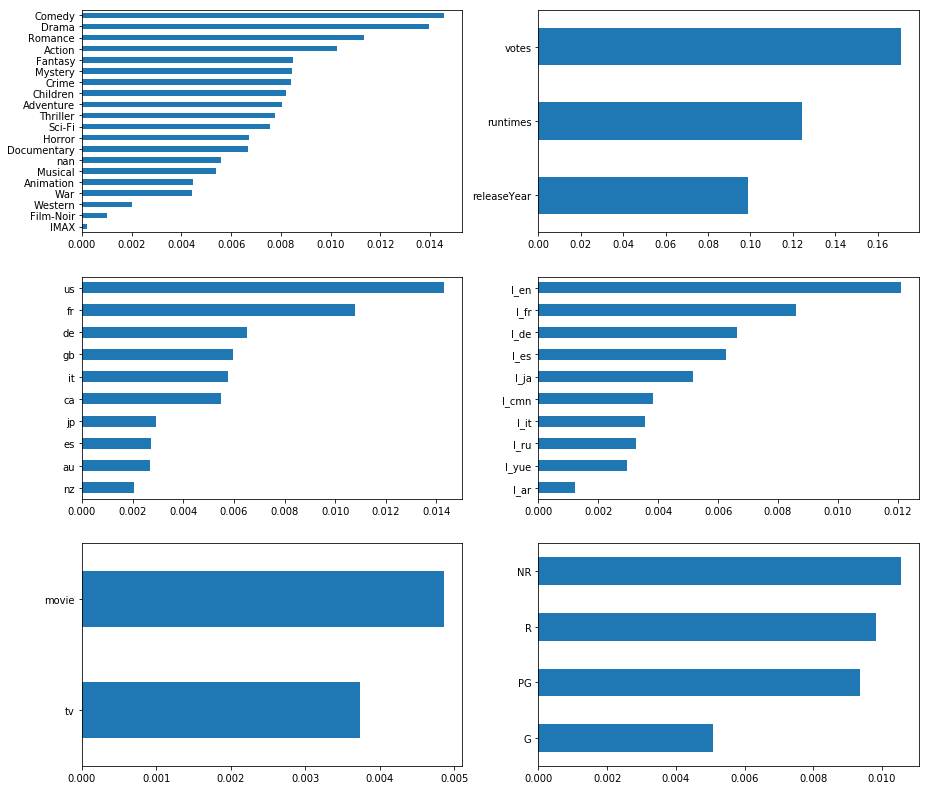

In [35]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 3]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
model = DecisionTreeRegressor()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

genreCols = feat_importances[:20]
featCols = feat_importances[[20,21,23]]
countryCols = feat_importances[24:34]
langCols = feat_importances[34:44]
kindCols = feat_importances[44:46]
ratingCols = feat_importances[46:]

c = [genreCols, featCols, countryCols, langCols, kindCols, ratingCols]
f, axes = plt.subplots(3, 2, figsize=(15, 5))
for i in range(6):
    c[i].sort_values(ascending = True).plot(kind='barh',ax=axes[i//2,i%2])    
    plt.subplots_adjust(bottom = 0.1 , top = 2.2)

## Regression for Feature Importance

In [121]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def plotFeatureImportance(df):
#     movieFeatures = ["imdbId", "imdbRating", "ccode", "lcode", "kind", "votes", "runtimes", "releaseYear"]
    y = df["userRating"]
    X = df[movieFeatures].drop(['imdbId','imdbRating'], axis = 1)
    scaleX = X[["votes", "runtimes"]]
    
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(scaleX.values)
    X[["votes", "runtimes"]] = scaler.transform(scaleX.values)
    reg = LinearRegression().fit(X, y)
    
    coefs = pd.DataFrame([], columns=['column', 'coeff'])
    coefs['column'] = X.columns
    coefs['coeff'] = reg.coef_
    coefs['absCoeff'] = abs(coefs['coeff'])
    coefs = coefs.sort_values('coeff', ascending = False)
#     print(coefs)
    c = [genreCols, featCols, countryCols, langCols, kindCols, ratingCols]
    f, axes = plt.subplots(3, 2, figsize=(15, 5))
    f.tight_layout(pad=3.0)
    for i in range(6):
    #     c[i].sort_values(ascending = True).plot(kind='barh',ax=axes[i//2,i%2])  
        y = list(coefs.loc[coefs.column.isin(list(c[i].index)),'coeff'])
        x = list(coefs.loc[coefs.column.isin(list(c[i].index)),'column'])
        plt.setp(axes[i//2,i%2].xaxis.get_majorticklabels(), rotation=45)
        axes[i//2,i%2].bar(x,y)
    #     axes[i//2,i%2].set_title('subplot 1')
        axes[i//2,i%2].set_xlabel('Feature')
        axes[i//2,i%2].set_ylabel('Regression Coefficient')
        plt.subplots_adjust(bottom = 1 , top = 2.5)

    

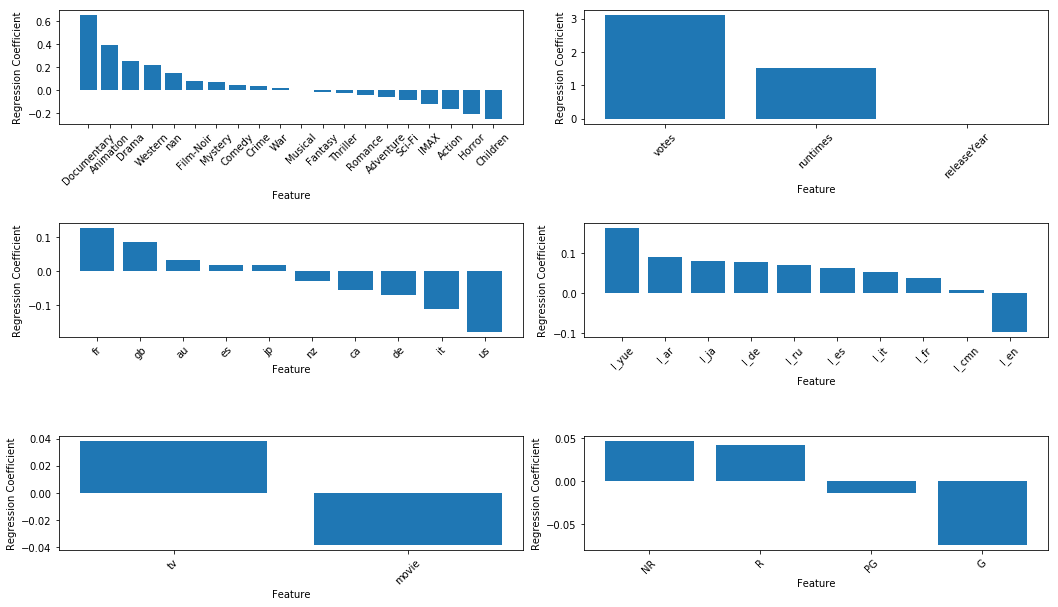

In [122]:
plotFeatureImportance(clusterAvgs[clusterAvgs["cluster"] == 0])

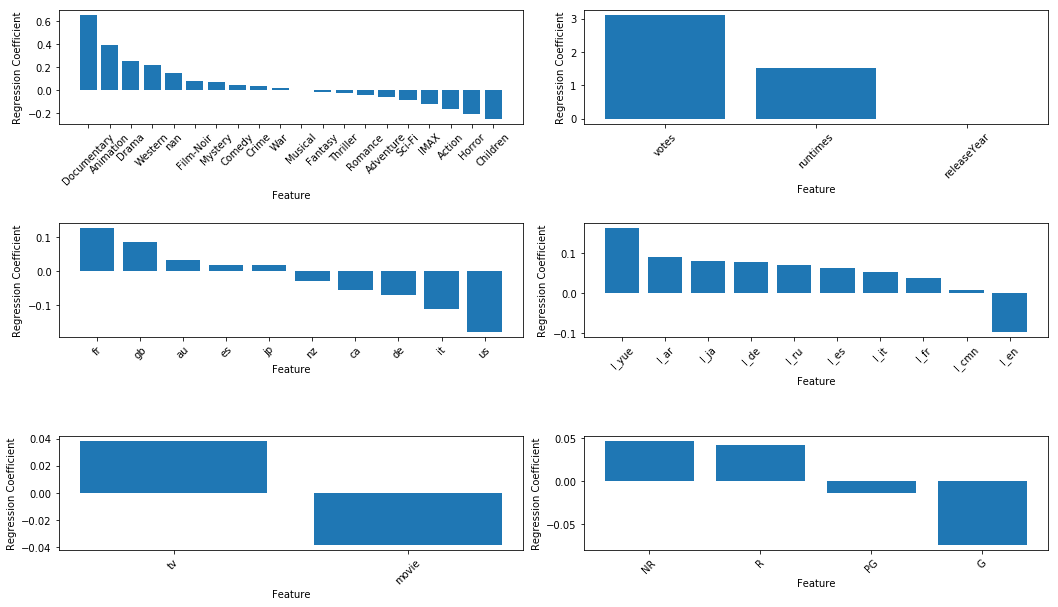

In [60]:
plotFeatureImportance(clusterAvgs[clusterAvgs["cluster"] == 0])

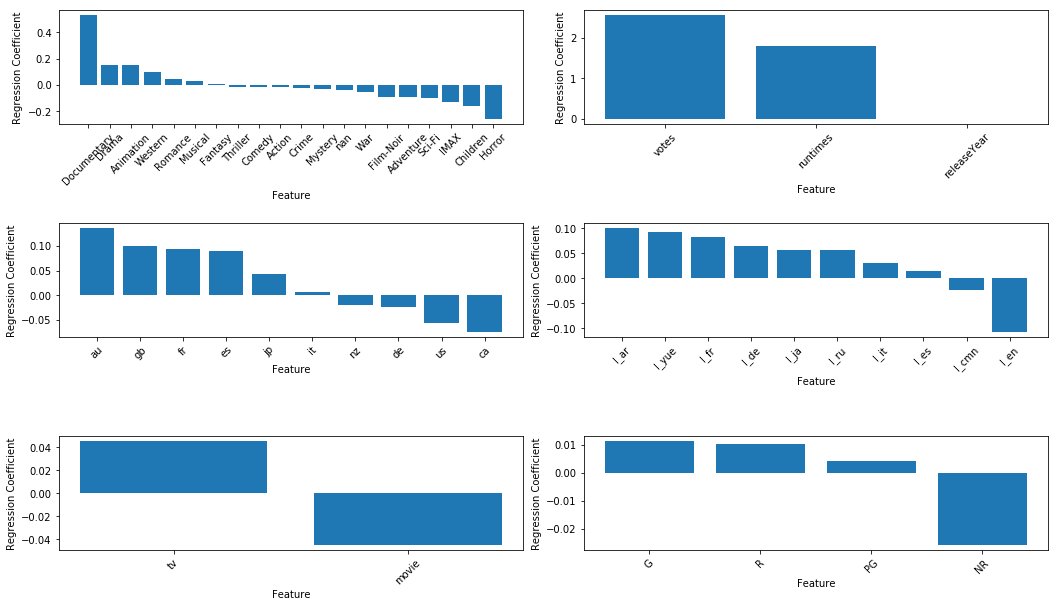

In [61]:
plotFeatureImportance(clusterAvgs[clusterAvgs["cluster"] == 1])

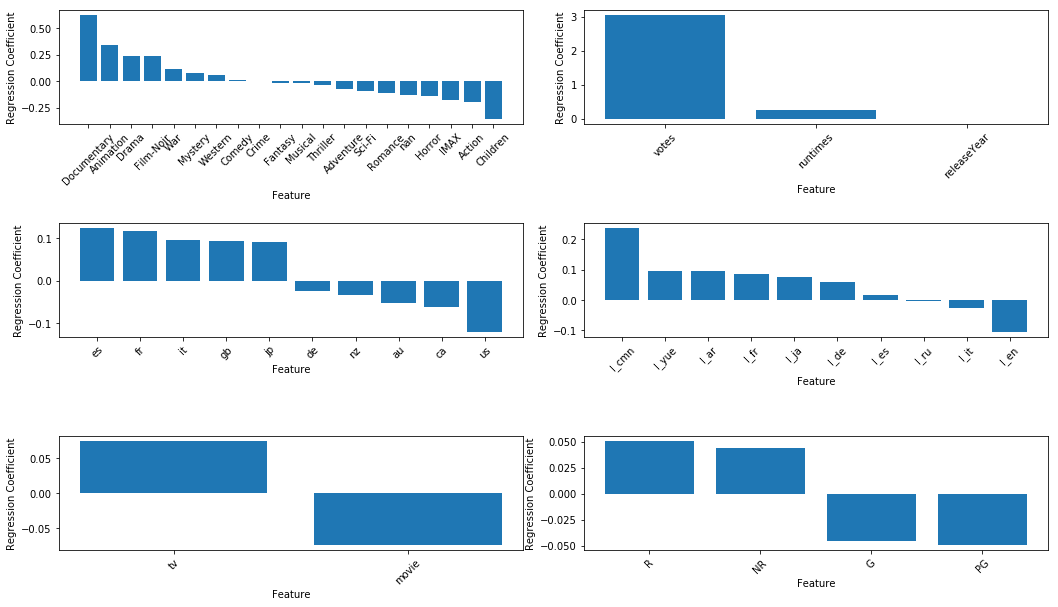

In [62]:
plotFeatureImportance(clusterAvgs[clusterAvgs["cluster"] == 2])

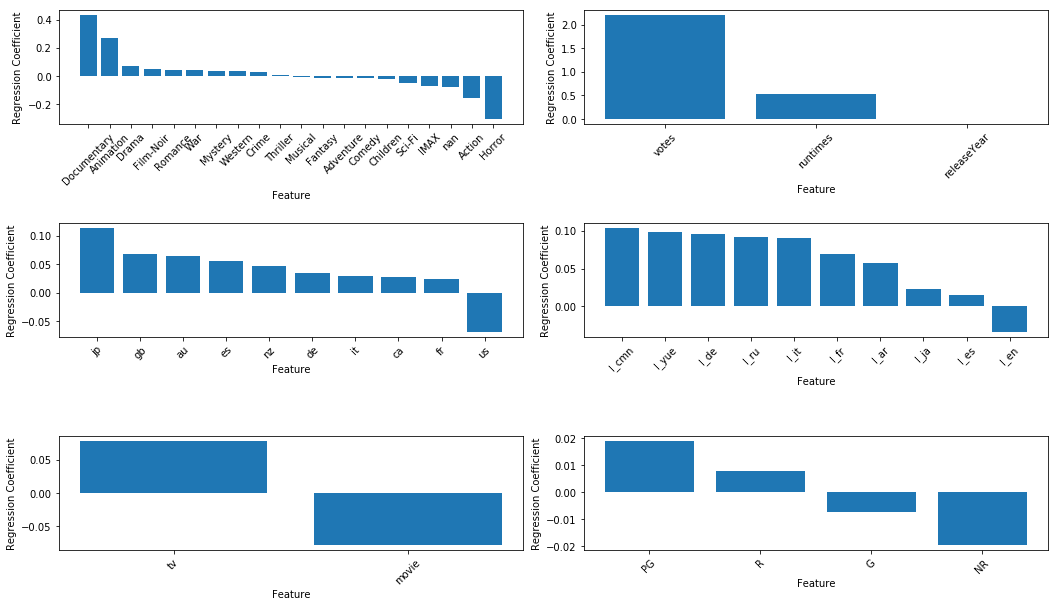

In [63]:
plotFeatureImportance(clusterAvgs[clusterAvgs["cluster"] == 3])

## Variance of Features

In [136]:
from statsmodels.formula.api import ols
# tips = sns.load_dataset("tips")

model = ols('userRating ~ runtimes + votes + C(releaseYear) + C(ccode) + C(lcode) + C(kind) + C(certificates)', data=clusterAvgs)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             userRating   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     2.417
Date:                Wed, 11 Mar 2020   Prob (F-statistic):          3.35e-291
Time:                        13:38:10   Log-Likelihood:                -48662.
No. Observations:               40314   AIC:                         1.030e+05
Df Residuals:                   37475   BIC:                         1.274e+05
Df Model:                        2838                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================================
                                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                          3.0619      1.134      2.700      0.007       0.839       5.285
C(releaseYear)[T.1894.0]                                                                                                           0.1661      0.969      0.171      0.864      -1.733       2.065
C(releaseYear)[T.1896.0]                                                                                                          -0.4994      0.969     -0.515      0.606      -2.399       1.400
C(releaseYear)[T.1902.0]                                                                                                           0.1279      0.920      0.139      0.889      -1.675       1.931
C(releaseYear)[T.1903.0]                                                                                                          -0.0473      0.890     -0.053      0.958      -1.792       1.698
C(releaseYear)[T.1904.0]                                                                                                          -0.8461      1.028     -0.823      0.411      -2.862       1.169
C(releaseYear)[T.1906.0]                                                                                                          -0.4665      0.919     -0.507      0.612      -2.268       1.335
C(releaseYear)[T.1907.0]                                                                                                          -0.2022      0.939     -0.215      0.829      -2.042       1.638
C(releaseYear)[T.1909.0]                                                                                                          -0.3831      1.028     -0.373      0.709      -2.398       1.631
C(releaseYear)[T.1910.0]                                                                                                          -0.1884      0.890     -0.212      0.832      -1.934       1.557
C(releaseYear)[T.1911.0]                                                                                                           0.0771      0.920      0.084      0.933      -1.725       1.880
C(releaseYear)[T.1912.0]                                                                                                          -0.2717      1.028     -0.264      0.791      -2.286       1.743
C(releaseYear)[T.1913.0]                                                                                                          -0.0689      0.974     -0.07

0.9999032343452385


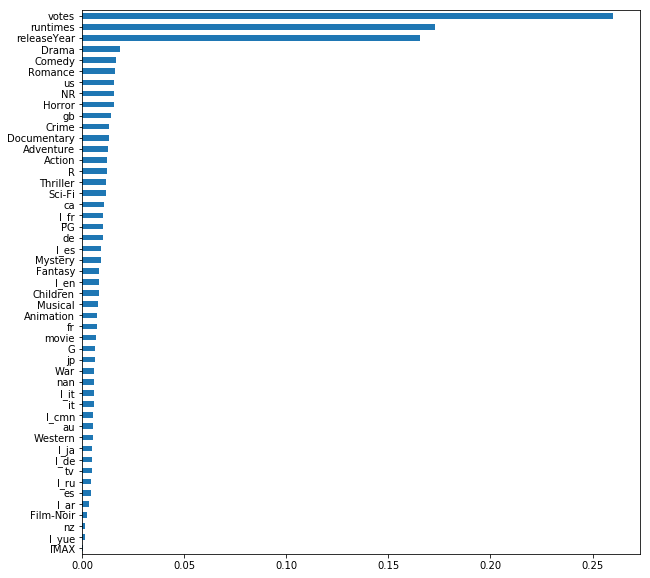

In [174]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 0]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.score(X,y))
plt.figure(figsize = (10,10))
feat_importances.sort_values(ascending = True).plot(kind='barh')    

0.9995926732810324


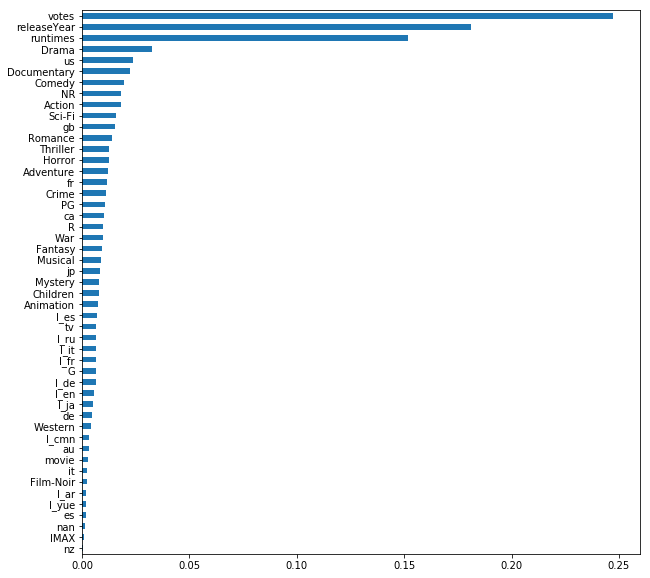

In [173]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 1]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.score(X,y))
plt.figure(figsize = (10,10))
feat_importances.sort_values(ascending = True).plot(kind='barh')    

0.9999976272063784


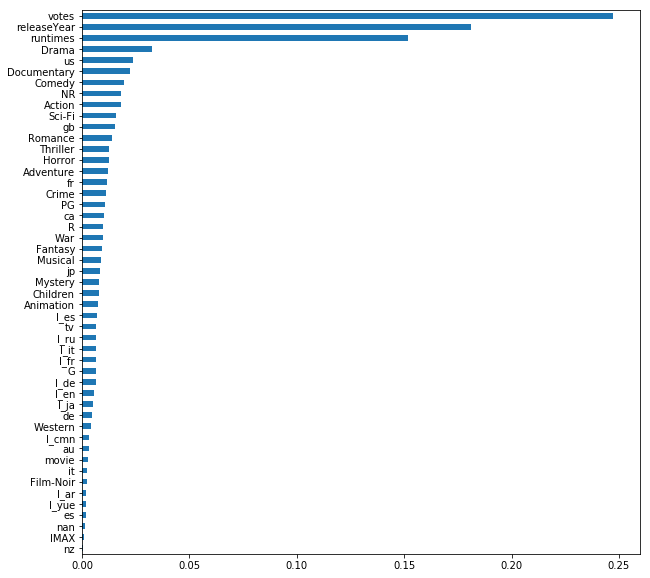

In [172]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 2]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
# scaleX = X[["votes", "runtimes"]]
    
# scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(scaleX.values)
# X[["votes", "runtimes"]] = scaler.transform(scaleX.values)
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.score(X,y))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize = (10,10))
feat_importances.sort_values(ascending = True).plot(kind='barh')    

0.9999711744297933


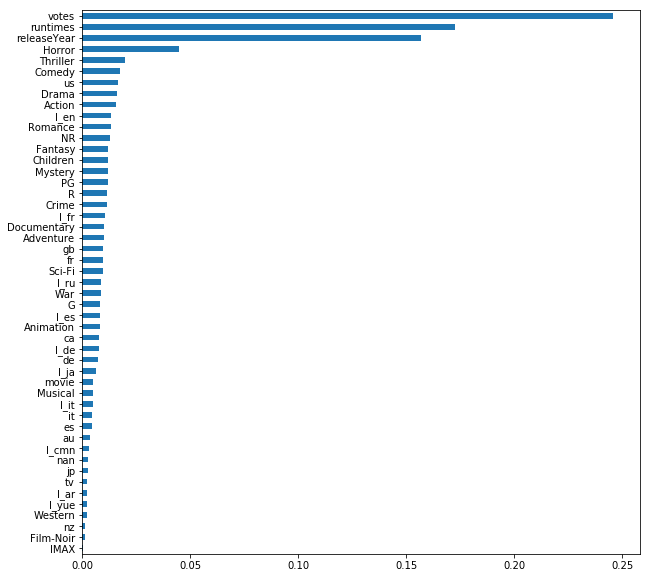

In [180]:
c1 = clusterAvgs[clusterAvgs["cluster"] == 3]
y = c1["userRating"]
X = c1[movieFeatures].drop('imdbId', axis = 1)
# scaleX = X[["votes", "runtimes"]]
    
# scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(scaleX.values)
# X[["votes", "runtimes"]] = scaler.transform(scaleX.values)
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.score(X,y))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize = (10,10))
feat_importances.sort_values(ascending = True).plot(kind='barh')    

In [181]:
feat_importances.sort_values(ascending = False)

votes          0.245794
runtimes       0.172424
releaseYear    0.156856
Horror         0.044754
Thriller       0.019857
Comedy         0.017583
us             0.016792
Drama          0.016255
Action         0.015777
l_en           0.013636
Romance        0.013485
NR             0.012974
Fantasy        0.012222
Children       0.012186
Mystery        0.011925
PG             0.011913
R              0.011633
Crime          0.011362
l_fr           0.010858
Documentary    0.010178
Adventure      0.009982
gb             0.009937
fr             0.009936
Sci-Fi         0.009740
l_ru           0.008863
War            0.008807
G              0.008350
l_es           0.008317
Animation      0.008167
ca             0.008072
l_de           0.007753
de             0.007205
l_ja           0.006617
movie          0.005340
Musical        0.005282
l_it           0.005277
it             0.004677
es             0.004535
au             0.003646
l_cmn          0.003117
nan            0.002879
jp             0

In [182]:
c1["Horror"].value_counts()

0    8465
1    1666
Name: Horror, dtype: int64

In [186]:
c1["tv"].value_counts()

0.0    9472
1.0     659
Name: tv, dtype: int64

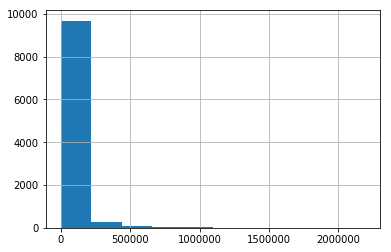

In [190]:
c1["votes"].hist()